In [1]:
# importing libraries
from keras.datasets import mnist
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import tree
import random
#from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# for visualisation
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
from IPython.display import Image  
from subprocess import call
from numpy import asarray
from sklearn.preprocessing import OrdinalEncoder
import scipy.io
import seaborn as sns
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, confusion_matrix


2023-08-16 10:36:30.270944: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


It's a common practice to split the training data into a training set and a test set. However, to avoid potential pitfalls like overfitting, it's often recommended to divide the data into three sets: a training set, a development set (often called a "validation set" or "dev set"), and a test set.

The training set is used to train the model, the validation set is used to tune parameters, validate model choices, and diagnose issues like underfitting or overfitting. Once the model is finalized, the test set is used to evaluate its performance on completely unseen data. This structure helps ensure that the model is generalized well and can perform reliably on new, unobserved data.

# load data

The MNIST dataset consists of tuples of numpy arrays. The data comes pre-divided into a training set with 60,000 observations and a test set with 10,000 observations. Each observation corresponds to a 28x28 pixel grayscale image of a handwritten digit and its associated label.

For model tuning purposes, the training data was further divided into a smaller training subset and a development (or validation) set. This division was made using the same proportion as the initial train-test split (1/6). For processing, each 28x28 pixel image was reshaped into a 1-dimensional array of 784 pixels..

In [2]:
# load data, first tuple has two arrays for the training data (observations/labels)
# Need to reshape the features into a single array
tp_mnist = mnist.load_data()
X_train_dev = tp_mnist[0][0].reshape(60000, 28*28)
y_train_dev = tp_mnist[0][1]

# second tuple split 10000, 28, 28, reshape 1D
X_test = tp_mnist[1][0].reshape(10000, 28*28)
y_test = tp_mnist[1][1]

# set random state
r = 41

# development set
X_train, X_dev, y_train, y_dev = train_test_split(X_train_dev, y_train_dev, test_size=0.17, random_state=r)

Check to make sure the data types are all the same:

In [3]:
print(X_test.dtype)
print(y_test.dtype)
print(X_train_dev.dtype)
print(y_train_dev.dtype) 

uint8
uint8
uint8
uint8


The histograms below compare the label distributions of the training and development sets. Both sets exhibit similar distributions, suggesting that they are representative of the overall data. 

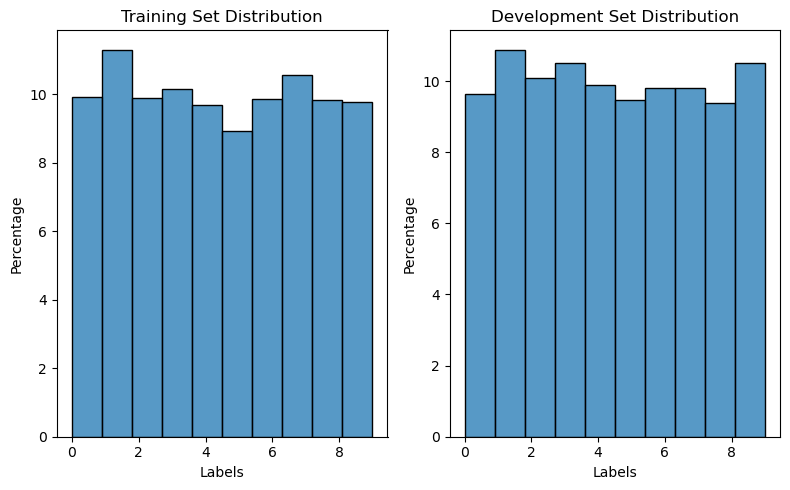

In [4]:
# Plot histograms to compare the distributions of 'y_train' and 'y_dev' in terms of percentage.
# This visual comparison helps ensure that both sets have representative distributions.
fig, ax = plt.subplots(1, 2, figsize=(8, 5))

# Plotting the histogram for y_train
sns.histplot(y_train, ax=ax[0], stat='percent', bins=10)
ax[0].set_title('Training Set Distribution')
ax[0].set_xlabel('Labels')
ax[0].set_ylabel('Percentage')

# Plotting the histogram for y_dev
sns.histplot(y_dev, ax=ax[1], stat='percent', bins=10)
ax[1].set_title('Development Set Distribution')
ax[1].set_xlabel('Labels')
ax[1].set_ylabel('Percentage')

plt.tight_layout()
plt.show()

A visualization that randomly selects an image from the training set and displays it with its associated y-value.

8


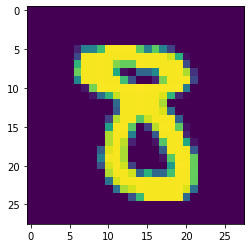

In [148]:
# randomly select a label, print its value
img_index = random.randrange(len(y_train))
print(y_train[img_index])

# show the corresponding image
plt.imshow(X_train[img_index].reshape(28,28))
plt.show()


● Use the RandomForestClassifier built into sklearn to create a classification
model.

First train a random forest classifier with no tuning to get a baseline accuracy.

In [149]:
# untuned forest
untuned_forest = RandomForestClassifier(n_estimators=10, random_state=r)
# fit model
untuned_forest.fit(X_train, y_train)
print("Untuned accuracy Random Forest:",untuned_forest.score(X_dev, y_dev))

Untuned accuracy Random Forest: 0.9458823529411765


TUNING:

First I tuned depth using the largest depth from the control model. This ran quite slowly so I reduced the number of estimators to 10.  Tuning depth, enables to prune the decision tree to simplify model.

I used the highest accuracy of the depths (31) as the model is running fast enough on my computer, I could have used 11 as this represents the best tradeoff of efficiency vs accuracy if I had a slower computer.

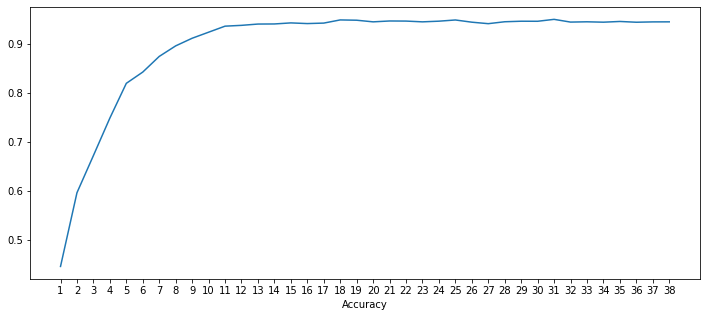

Best performance reached at depth of: 31


In [150]:
# find the largest tree depth of all estimators in the forest
max_tree_depth_in_forest = max([estimator.tree_.max_depth for estimator in untuned_forest.estimators_])

# recalculate accuracy for depths between 1 and max_tree_depth_in_forest
pruned_scores = [] 
pruned_depths = range(1, max_tree_depth_in_forest + 1)
for d in pruned_depths:
  forest = RandomForestClassifier(n_estimators=10, random_state=r, max_depth=d)
  forest.fit(X_train, y_train)
  score = forest.score(X_dev, y_dev)
  pruned_scores.append(score)

# plot the outcome
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(pruned_depths, pruned_scores)
plt.xlabel("Max_depth values")
plt.xlabel("Accuracy")
ax.xaxis.set_ticks(pruned_depths)
plt.show()

# fitting the chosen tree using test set
best_depth = pruned_depths[np.argmax(pruned_scores)]
print('Best performance reached at depth of:', best_depth)

Then I tuned number of estimators between 50 and 500

I plotted the results, 250 estimators produced the best accuracy

50
100
150
200
250
300
350
400
450


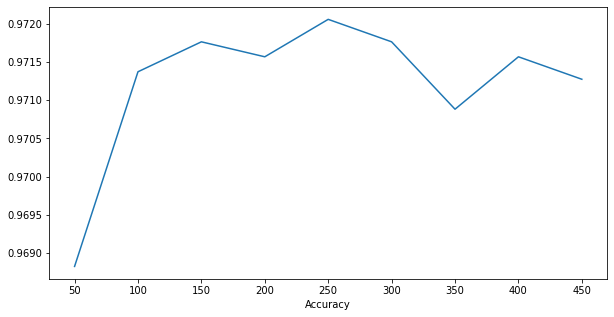

Best performance reached at estimator count of: 250


In [73]:
# create a list of estimator counts between 50 and 10000
n_estimators = range(50, 500, 50)

# run classifier for each estimator count, record accuracy
estimator_scores = [] 
for n in n_estimators:
  forest = RandomForestClassifier(n_estimators=n, random_state=r, max_depth=best_depth)
  forest.fit(X_train, y_train)
  score = forest.score(X_dev, y_dev)
  estimator_scores.append(score)

# plot the outcome
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(n_estimators, estimator_scores)
plt.xlabel("n_estimators")
plt.xlabel("Accuracy")
ax.xaxis.set_ticks(n_estimators)
plt.show()

# calculate and display the best number of estimators based on results
best_estimator = n_estimators[np.argmax(estimator_scores)]
print('Best performance reached at estimator count of:', best_estimator)

The tuning steps have automatically set the best values for best tree depth and number of estimators

I retrained the model with the new parameters and increased the models accuracy by approximately 2.5%.

In [151]:
# rerunning the model with the tuned tree depth value and tuned estimator count
forest = RandomForestClassifier(n_estimators=best_estimator, random_state=r, max_depth=best_depth)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

# output the old vs new accuracy scores
print("Untuned accuracy:",untuned_forest.score(X_dev, y_dev))
print("Tuned accuracy:",forest.score(X_test, y_test))

Untuned accuracy: 0.9458823529411765
Tuned accuracy: 0.9692


See below confusion matrix, plotted as a heat map to show how the model performed. 

It looks like the model occasionally struggles to differentiate between 4 and 9.

Overall, it is very good at finding the correct value

Text(0.5, 1.0, 'Accuracy Score: 0.9692')

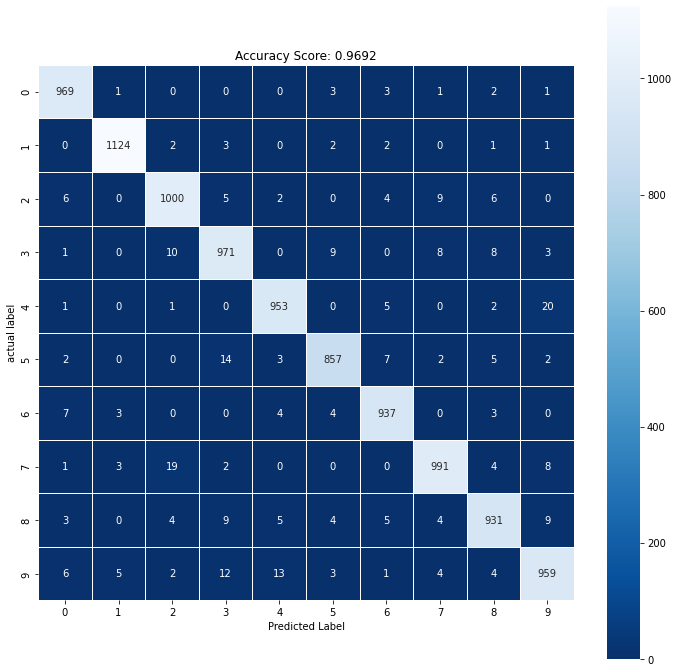

In [127]:
# Use sklearn to obtain a confusion matrix comparing the predictions
# to the gold labels.
confusion_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,12))
sns.heatmap(confusion_matrix, annot=True, linewidth=.5, square=True, cmap='Blues_r',fmt='0.4g')

plt.ylabel('actual label')
plt.xlabel('Predicted Label')
plt.title(f'Accuracy Score: {forest.score(X_test, y_test)}')

A classification report provides metrics to measure the quality of predictions from a classification algorithm. It doesn't just detail how many predictions are true or false, but it breaks these down further into True Positives (TP), False Positives (FP), True Negatives (TN), and False Negatives (FN). The metrics derived from these values in a classification report include:

Support: The number of actual occurrences of the class in the specified dataset.

Precision: Precision gauges the accuracy of positive predictions. It's the ratio of correctly predicted positive observations to the total predicted positives. Defined as:

Precision= TP/(TP + FP)

Recall (or Sensitivity): Recall captures the ability of a classifier to correctly identify all positive instances. It's the ratio of correctly predicted positive observations to all the observations in the actual class. Defined as: Recall = TP/(TP+FN)

F1 Score: The F1 Score is the weighted harmonic mean of Precision and Recall. The best possible F1 Score is 1.0, indicating perfect precision and recall, while the worst is 0.0. It's defined as:
F1 Score = 2*(Recall * Precision) / (Recall + Precision)

In [107]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.97      1032
           3       0.96      0.96      0.96      1010
           4       0.97      0.97      0.97       982
           5       0.97      0.96      0.97       892
           6       0.97      0.98      0.98       958
           7       0.97      0.96      0.97      1028
           8       0.96      0.96      0.96       974
           9       0.96      0.95      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

